# Lab 6: One Vs All Regularized Classifier

For multiclass classification there is two main method "One vs one classifier" and "One vs all classifier" (called also ""One vs the rest). The first method train $\frac{K\times(K-1)}{2}$ classifiers for $K$ classes and it compare all classes between each other two by two. While, "One vs All classifier" compare each class with the $K-1$ remaining class together. Thus, we train only $K$ classifier. In this session, we will use "One vs all" approach to classify handwritten digits into 10 ($K=10$) classes with labels from 0 to 9.

## Preparation

We'll need the following libraries:

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.image as mpimg
from math import floor

In [2]:
def Display_digits(X_display,Y_display):
    """
    display digit image contained in X_display and print their labels contained in Y_display
    """
    
    # calculate number and size of patches fo each digit image
    nbr_select=X_display.shape[0] # number of digits to display
    origin_img_size=int(np.sqrt(X_display.shape[1]))
    nbr_patch_horiz=int(np.floor(np.sqrt(nbr_select)))
    nbr_patch_vertic=int(np.ceil(nbr_select/nbr_patch_horiz))
    img_width=20
    img_height=20
    
    # create Display_matrix that contains all image patches
    Display_matrix=-np.ones((nbr_patch_vertic*(img_height+1)-1,nbr_patch_horiz*(img_width+1)-1))
    for i in range(nbr_patch_vertic):
        for j in range(nbr_patch_horiz):
            if (i*nbr_patch_horiz+j>=nbr_select):
                break
            Display_matrix[i*(img_height+1):(i+1)*img_height+i,j*(img_width+1):(j+1)*img_width+j]=np.reshape(X_display[i*nbr_patch_horiz+j,np.arange(origin_img_size**2)%origin_img_size<img_height][:img_width*img_height],(img_height,img_width),order='F')
    plt.figure('dataset',figsize=(max(3,nbr_patch_horiz),max(3,nbr_patch_vertic)))
    plt.imshow(Display_matrix,cmap="gray",vmax=1,vmin=-1)
    plt.axis('off')
    plt.show()
    
    # print digit labels
    print(np.reshape(np.concatenate((Y_display[:,0].astype(int),-np.ones((nbr_patch_horiz*nbr_patch_vertic-nbr_select),dtype=int))),(nbr_patch_vertic,nbr_patch_horiz)))

In [3]:
def predict_your_digits(filename,Logistic_Regr_List):
    """
    Predict the written digit on the input image
    
    Args:
        filename: input image filename
        Logistic_Regr_List: list of K trained logistic classifiers
    
    Return:
        predicted label for input image
    """
    # read image file
    img=mpimg.imread(filename)
    img=np.mean(img,axis=-1)  # convert to grayscale image
    
    # resize the image
    height,width = img.shape
    height_step = floor(height/20) 
    width_step = floor(width/20) 
    if(height_step>0) and (width_step>0):
        img=img[::height_step,::width_step]
    else:
        img=resize(img,(20,20),order=1)
        
    # change the color scale from 0-255 integer to [-1,1] float
    img=(img.T/128-1)
    
    # draw the digit image
    #plt.figure('handwritten digit',figsize=(9,4))
    plt.imshow(img.T,cmap="gray",vmax=1,vmin=-1)
    plt.axis('off')
    plt.show()
    
    # predict the digit
    prediction=Predict_OneVsAll(Logistic_Regr_List,img.flatten()[np.newaxis,:])
    return prediction

**Question 1: **
- Load data from "hand_writing.txt" file in "hand_writing" variable and check its size. (use [loadtxt](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html) function from numpy library)  
This dataset contains 5000 of $20 \times 20$ pixel images. These images are flatten and saved on single line of 400 pixels on our dataset. Each columns of the 400 of hand_writting dataset represent pixel intensity (a feature for our classifier).
- Extract the number of samples, the features, the output and the number of features.
- Determine the number of classes. You can use the [unique](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) function of numpy.

In [4]:
# load data
# Type your code here
hand_writing =  np.loadtxt("hand_writing.txt")
hand_writing.shape

(5000, 401)

In [5]:
hand_writing[0]

array([ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e

In [6]:
hand_writing[0].shape

(401,)

In [7]:
hand_writing[0].min()

-0.057515

In [8]:
hand_writing[1].max()

1.063432

In [9]:
# Type your code here
m = hand_writing.shape [0]      # number of samples/images in hand_writing dataset = 5000
X = hand_writing[:,:-1]  
Y = hand_writing[:,-1,np.newaxis]
n = X.shape[1]         # number of features (number of pixel per image)
nbr_class = np.unique(Y)        # number of classes K
#nbr_class = np.unique(Y).shape[0]        # number of classes K


In [10]:
nbr_class

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

 <font color="blue">Comments : 
- X : For each line we take all the columns except the last one (Y, to predict)
- Y : For each line we take only the last column

In [11]:
nbr_class

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [12]:
 np.unique(Y)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [13]:
n, Y

(400, array([[0.],
        [0.],
        [0.],
        ...,
        [9.],
        [9.],
        [9.]]))

In [14]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

 <font color="blue">Note : 
 - m : nb of samples = 5000
 - X : for all samples/images, each columns of the 400 of hand_writting dataset represent pixel intensity (a feature for our classifier) => features
 - Y : output : the "real number" represented by the image, the "real" class to which the sample belongs to
 - n : number of features = 400 (400 columns/pixels)
 - nbr_class : number of classes (each image can represents either number 0,1,2,3,4,5,6,7,8 or 9) = 10 classes

Let's visualize some digits from the hand_writing dataset

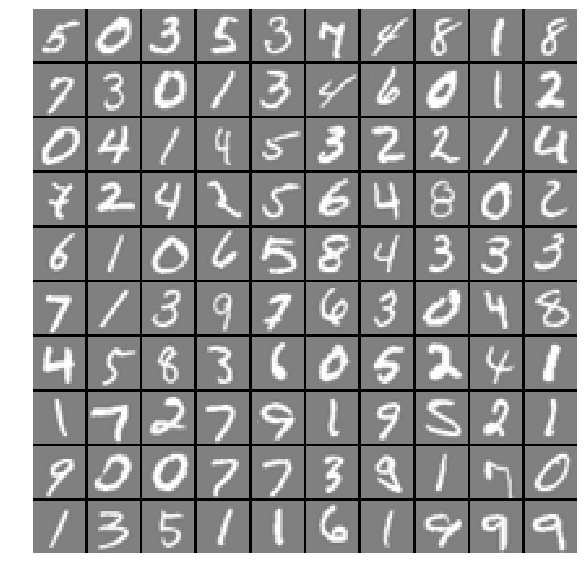

[[5 0 3 5 3 7 4 8 1 8]
 [7 3 0 1 3 4 6 0 1 2]
 [0 4 1 4 5 3 2 2 1 4]
 [7 2 4 2 5 6 4 8 0 2]
 [6 1 0 6 5 8 4 3 3 3]
 [7 1 3 9 7 6 3 0 4 8]
 [4 5 8 3 6 0 5 2 4 1]
 [1 7 2 7 9 1 9 5 2 1]
 [9 0 0 7 7 3 9 1 7 0]
 [1 3 5 1 1 6 1 9 9 9]]


In [15]:
# visualize some digits from hand_writing dataset
nbr_select=100
rand_perm=np.random.permutation(m)
X_display=X[rand_perm[:nbr_select],:]
Display_digits(X_display,Y[rand_perm[:nbr_select],:])

**Question 2: **
- Determine the number of classes. You can use the [unique](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) function of numpy.
- Create a vector y composed of ones when Y = digit and zeros when Y <> digit.
- Use  [fit](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit) function of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) sklearn class to train "logistic_regr" K classifiers with "X" and "y" input vectors.  
**Hint:** Don't forgot to define the regularization parameter C predefined in [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class where $C=\frac{1}{\lambda}$

In [16]:
# one vs all train function
def Train_OneVsAll(X,Y,lambda_):
    """
    Train K logitic classifiers for multiclass classification with  One vs All approach
    
    Args:
        X: input digit images
        Y: labels of the digit images
        lambda_: Regularization parameter
    
    Return:
        Logistic_Regr_List: list of K logistic classifier one per class
    """
    # Determine the number of the classes 
    # type your code here
    K= np.unique(Y).shape[0]
    #print(K)
    
    Logistic_Regr_List=[]
    
    for digit in range(K):
        # Create a vector y composed of ones when Y = digit and zeros when Y <> digit
        # type your code here
        
        regularization_param = LogisticRegression(C=1/lambda_)
        
        #y= [1 if output == digit else 0 for output in Y]
        #print(y)
        y = np.zeros(Y.shape[0])
        y[Y[:,0]==digit] = 1
        
        #y = np.asarray(y)
        y=y.reshape((y.shape[0],))
        
        # create logistic regression classifier object
        # type your code here   
        logistic_regr= regularization_param.fit(X,y)
        
        # train logistic regression classifier object
        # type your code here
                                   
        
        Logistic_Regr_List.append(logistic_regr)      # append the trained logistic classifier to the output list
    return Logistic_Regr_List


# one vs all train function
def Train_OneVsAll2(X,Y,lambda_):
    """
    Train K logitic classifiers for multiclass classification with  One vs All approach

    Args:
        X: input digit images
        Y: labels of the digit images
        lambda_: Regularization parameter
    
    Return:
        Logistic_Regr_List: list of K logistic classifier one per class
    """
    # Determine the number of the classes 
    # type your code here
    K=len(nbr_class)
    
    Logistic_Regr_List=[]
    
    for digit in range(K):
        # Create a vector y composed of ones when Y = digit and zeros when Y <> digit
        # type your code here
        reg = LogisticRegression(C=1/lambda_)
        y = np.zeros(Y.shape[0])
        y[Y[:,0]==digit] = 1
        y=y.reshape((y.shape[0],))
        # create logistic regression classifier object
        # type your code here   
        logistic_regr=reg.fit(X, y)
        
        # train logistic regression classifier object
        # type your code here
                                   
        
        Logistic_Regr_List.append(logistic_regr)      # append the trained logistic classifier to the output list

    return Logistic_Regr_List

 <font color="blue">Note :
    For each classifier, we have a different y and the same regularization parameter.
    For example, if Y = [0,2,3,0,1]
    The y for the digit 0 is : y = [1,0,0,1,0]

**Question 3: **
- Use [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) function to predict probability of belonging to the corresponding classifier label.
- Use [argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) function from numpy library to predict label with max probability from the calculated probability matrix "pred_proba".

In [17]:
# one vs all predition function
def Predict_OneVsAll(classifier_list,X):
    """
    Predict the labels of input images in 'X' array using the trained K logitic classifiers 'classifier_list' 

    Return:
        y_pred: vector of predicted label for each input image
    """
    # Determine the number of the classes 
    K = len(classifier_list)                
    pred_proba=np.zeros((X.shape[0],K))     # array contains m line one for each input and K columns represent the probability to
                                            # belong to the corresponding classifier label
    
    # calculate the probabilty for an input image to have as label the number of classifier 'digit' from 0 to K
    for digit in range(K):
        # type your code here
        y = classifier_list[digit]
        
        pred_proba[:,digit]= y.predict_proba(X)[:,1]
        
    # type your code here
    y_pred= np.argmax(pred_proba, axis=1)    
    return y_pred


# one vs all predition function
def Predict_OneVsAll2(classifier_list,X):
    """
    Predict the labels of input images in 'X' array using the trained K logitic classifiers 'classifier_list' 

    Return:
        y_pred: vector of predicted label for each input image
    """
    # Determine the number of the classes 
    K = len(classifier_list)     
    pred_proba=np.zeros((X.shape[0],K))     # array contains m line one for each input and K columns represent the probability to
                                            # belong to the corresponding classifier label
    # calculate the probabilty for an input image to have as label the number of classifier 'digit' from 0 to K]
    for digit in range(K):
        reg = classifier_list[digit]
        # type your code here
        pred_proba[:,digit] = reg.predict_proba(X)[:,1]
        # type your code here
    y_pred = np.argmax(pred_proba, axis=1)
    return y_pred

**Question 4: ** 
- Call "Train_OneVsAll" to generate the logistic regression list.
- Call "Predict_OneVsAll" function to predict classes "y_pred" of our dataset 

In [18]:
# train K logistic classifiers
lambda_ = .1 # reguralization parameter
# type your code here
Logistic_Regr_List = Train_OneVsAll(X,Y,lambda_)  
#predict class on training dataset
# type your code here
y_pred = Predict_OneVsAll(Logistic_Regr_List,X)   

d:\Profiles\cpov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\Profiles\cpov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\Profiles\cpov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\Profiles\cpov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\Profiles\cpov\AppData\Local\Continuum\anaconda3\lib\site-packages\skl

**Question 5: ** 
- Calculate the "train_accuracy". What do you notice?

In [19]:
# calculate train accuracy
# type your code here
train_accuracy =  sum(y_pred[:,np.newaxis]==Y)/len(Y)
print("train accuracy= ",train_accuracy*100 ,"%")

train accuracy=  [96.5] %


 <font color="blue">Note :
    We have a very high train-accuracy. We have train our model very well for the training dataset.

**Question 6: **
- Make your own digit images and call "predict" function from "predict_your_digits" module to see how well our trained classifier will behave on your handwritten digits.  
**Hint:** You could use this online tool [https://www.youidraw.com/apps/painter/](https://www.youidraw.com/apps/painter/) to draw a digit image . It is recommended to make $400\times400$ pixels image and to draw with a white pencil of size 50 on gray background.

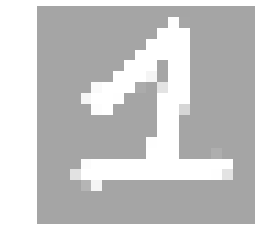

the digit in the image is 1  our One Vs All classifier predict [3]


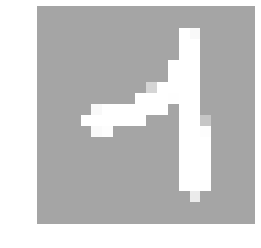

the digit in the image is 2  our One Vs All classifier predict [3]


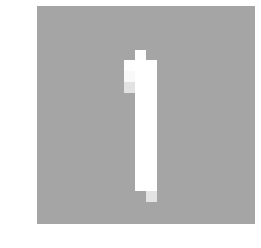

the digit in the image is 3  our One Vs All classifier predict [3]


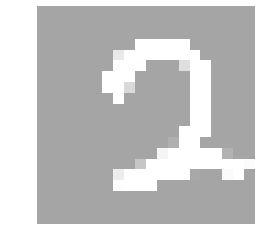

the digit in the image is 4  our One Vs All classifier predict [2]


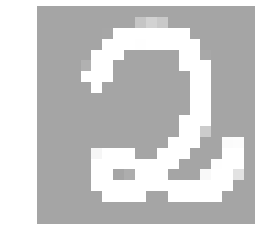

the digit in the image is 5  our One Vs All classifier predict [2]


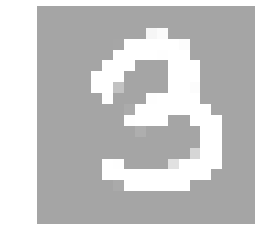

the digit in the image is 6  our One Vs All classifier predict [3]


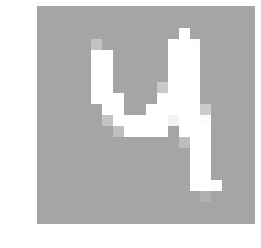

the digit in the image is 7  our One Vs All classifier predict [3]


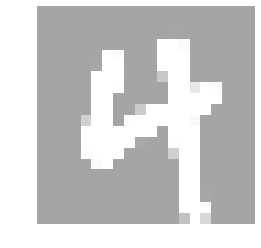

the digit in the image is 8  our One Vs All classifier predict [3]


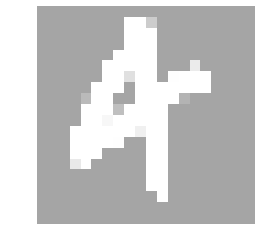

the digit in the image is 9  our One Vs All classifier predict [3]


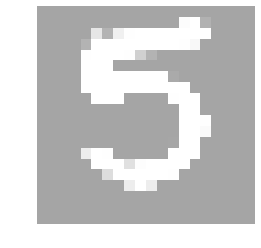

the digit in the image is 10  our One Vs All classifier predict [3]


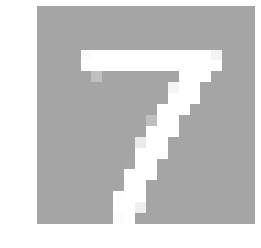

the digit in the image is 11  our One Vs All classifier predict [3]


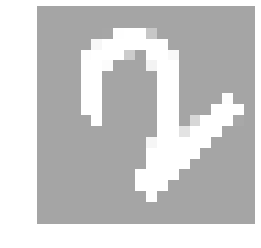

the digit in the image is 12  our One Vs All classifier predict [3]


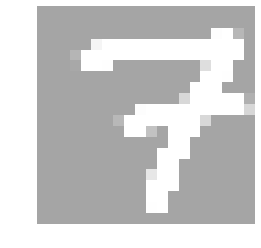

the digit in the image is 13  our One Vs All classifier predict [3]


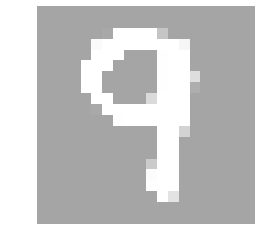

the digit in the image is 14  our One Vs All classifier predict [3]


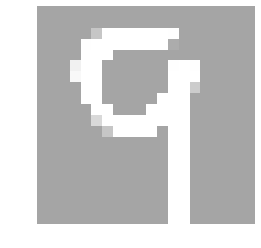

the digit in the image is 15  our One Vs All classifier predict [3]


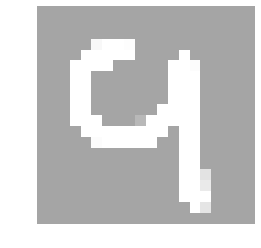

the digit in the image is 16  our One Vs All classifier predict [2]


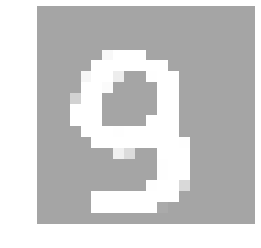

the digit in the image is 17  our One Vs All classifier predict [3]


In [20]:
# test our multiclass classifier
for c in range(1,18):
    predict_digit=predict_your_digits("image_"+str(c)+".jpg",Logistic_Regr_List)
    print("the digit in the image is",c," our One Vs All classifier predict",predict_digit)

 <font color="blue">Note :
    We have a made 18 differents images to test our model, including samples with different number writing style ( for 2, 4, 9, 7 for example) and ambigus cases ( 9 that can be identified as 3, 7 that can be identified as 1)
    
We find out that even though we had a good train accuracy, our model doesn't workkwell with those new images. In fact, it can only identifies 2 and 3 correctly, but for the other samples, it identified them either as 2 or 3.

In [21]:
Y = [0,1,2,3,4,5]
for digit in range(5):
    l = [1 if output is digit else 0 for output in Y]
    print(l)

[1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 1, 0]
